### **Import Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **Import Library**

In [0]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
import keras
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

### **Load Data**

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/DATA RD/')
Train = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATASETS/Data Split/Train/*')
Val=glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATASETS/Data Split/Validation/*')
Test=glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATASETS/Data Split/Test/*')

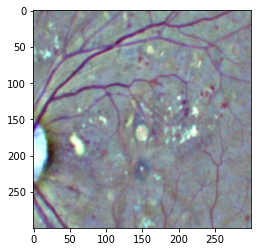

In [5]:
import matplotlib.image as mpimg
for ima in Train[600:601]:
     img=mpimg.imread(ima)
     imgplot = plt.imshow(img)
     plt.show()

### **Data Preparation**

In [0]:
nrows = 224
ncolumns = 224
channels = 3  

def read_and_process_image(list_of_images):
    
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Normal' in image:
            y.append(0)
        elif 'Mild' in image:
            y.append(1)
        elif 'Moderate' in image:
            y.append(2)
        elif 'Severe' in image:
            y.append(3)

    
    return X, y

In [0]:
X_train, y_train = read_and_process_image(Train)
X_val, y_val = read_and_process_image(Val)
X_test, y_test = read_and_process_image(Test)

In [8]:
import seaborn as sns
import gc 
gc.collect()

#Convert list to numpy array
X_train = np.array(X_train)
y_train= np.array(y_train)

X_val = np.array(X_val)
y_val= np.array(y_val)

X_test = np.array(X_test)
y_test= np.array(y_test)

print('Train:',X_train.shape,y_train.shape)
print('Val:',X_val.shape,y_val.shape)
print('Test',X_test.shape,y_test.shape)

Train: (6000, 224, 224, 3) (6000,)
Val: (1500, 224, 224, 3) (1500,)
Test (500, 224, 224, 3) (500,)


Text(0.5, 1.0, 'Total Data Training')

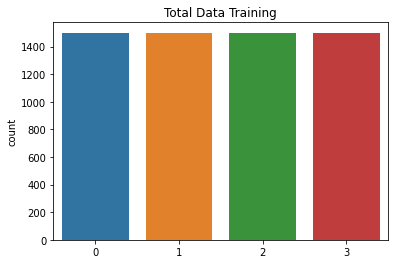

In [9]:
sns.countplot(y_train)
plt.title('Total Data Training')

Text(0.5, 1.0, 'Total Data Validasi')

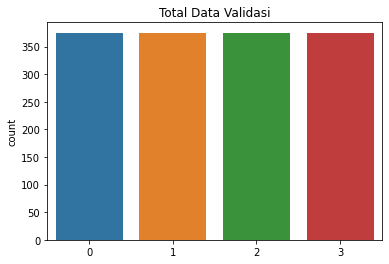

In [10]:
sns.countplot(y_val)
plt.title('Total Data Validasi')

Text(0.5, 1.0, 'Total Data Test')

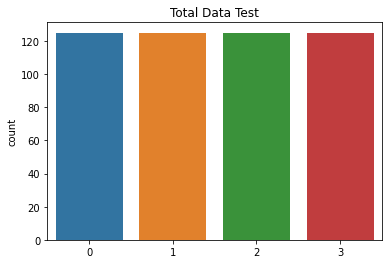

In [11]:
sns.countplot(y_test)
plt.title('Total Data Test')

In [12]:
y_train_ohe = pd.get_dummies(y_train)
y_val_ohe=pd.get_dummies(y_val)
y_test_ohe=pd.get_dummies(y_test)

y_train_ohe.shape,y_val_ohe.shape,y_test_ohe.shape

((6000, 4), (1500, 4), (500, 4))

### **Model Parameters**

In [0]:
batch_size = 16
EPOCHS = 100
WARMUP_EPOCHS = 2
LEARNING_RATE = 0.001
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

### **Data Generator**

In [0]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(
                                  rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

test_datagen=tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size=batch_size)
val_generator = test_datagen.flow(X_val, y_val_ohe, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test_ohe, batch_size=batch_size)

### **Define Model**

In [16]:
IMG_SHAPE = (224, 224, 3)
base_model =tf.keras.applications.MobileNetV2(weights='imagenet', 
                                       include_top=False,
                                       input_shape=IMG_SHAPE)
x =tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x =tf.keras.layers.Dropout(0.5)(x)
x =tf.keras.layers.Dense(2048, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
final_output =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output')(x)
model =tf.keras.models.Model(inputs=base_model.inputs,outputs=final_output)

9412608/9406464 [==============================] - 0s 0us/step


### **Train Top Layers**

In [17]:
for layer in model.layers: 
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [18]:
import time

start = time.time()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=val_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

end = time.time()
print('Waktu Training:', end - start)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
375/375 [==============================] - 66s 176ms/step - loss: 1.3452 - accuracy: 0.4800 - val_loss: 0.9711 - val_accuracy: 0.5827
Epoch 2/2
375/375 [==============================] - 65s 174ms/step - loss: 0.9970 - accuracy: 0.5377 - val_loss: 1.0779 - val_accuracy: 0.5101
Waktu Training: 140.7294180393219


### **Train Fine Tuning**

In [19]:
for layer in model.layers:
  layer.trainable = True

es =tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es]
optimizer =tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [20]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=val_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/100
375/375 [==============================] - 68s 182ms/step - loss: 0.9314 - accuracy: 0.6422 - val_loss: 42.7204 - val_accuracy: 0.2513
Epoch 2/100
375/375 [==============================] - 66s 177ms/step - loss: 0.7625 - accuracy: 0.6983 - val_loss: 21.6590 - val_accuracy: 0.2500
Epoch 3/100
375/375 [==============================] - 66s 175ms/step - loss: 0.7128 - accuracy: 0.7157 - val_loss: 19.8760 - val_accuracy: 0.2560
Epoch 4/100
375/375 [==============================] - 66s 176ms/step - loss: 0.6372 - accuracy: 0.7430 - val_loss: 29.2427 - val_accuracy: 0.2493
Epoch 5/100
375/375 [==============================] - 66s 176ms/step - loss: 0.6144 - accuracy: 0.7512 - val_loss: 2.8217 - val_accuracy: 0.4315
Epoch 6/100
375/375 [==============================] - 66s 175ms/step - loss: 0.5845 - accuracy: 0.7662 - val_loss: 8.1787 - val_accuracy: 0.3474
Epoch 7/100
375/375 [==============================] - 65s 174ms/step - loss: 0.5577 - accuracy: 0.7805 - val_loss: 2.72

### **Model Graph**

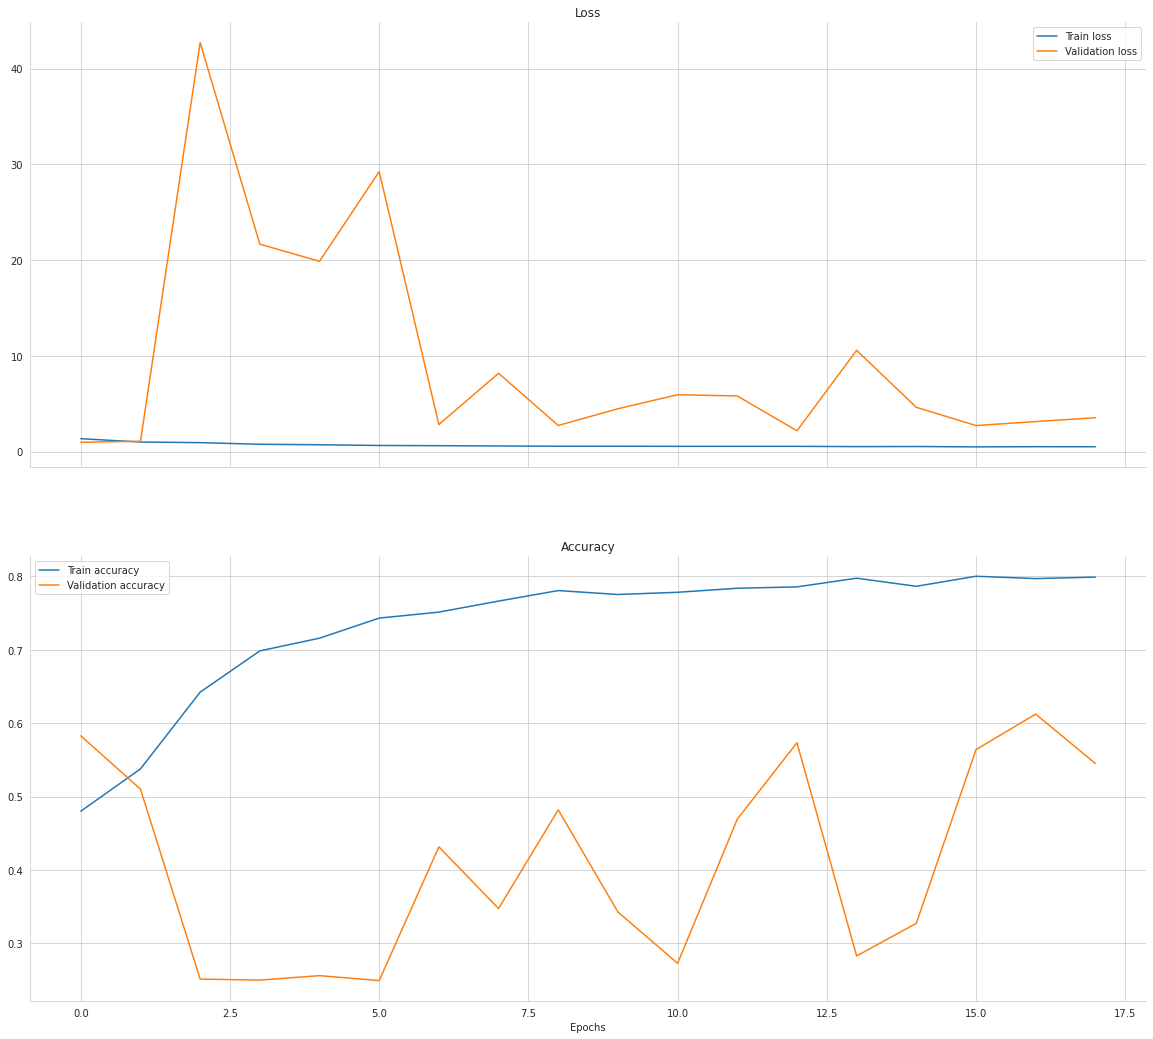

In [21]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 18))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### **Evaluate Model**

In [22]:
loss_Val, acc_Val = model.evaluate(X_val, y_val_ohe,batch_size=1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_Val, loss_Val))

1500/1500 [==============================] - 9s 6ms/step - loss: 2.1838 - accuracy: 0.5713
Validation: accuracy = 0.571333  ;  loss_v = 2.183751


In [0]:
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(val_generator)
    scores = model.predict(im, batch_size=val_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)

In [0]:
lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

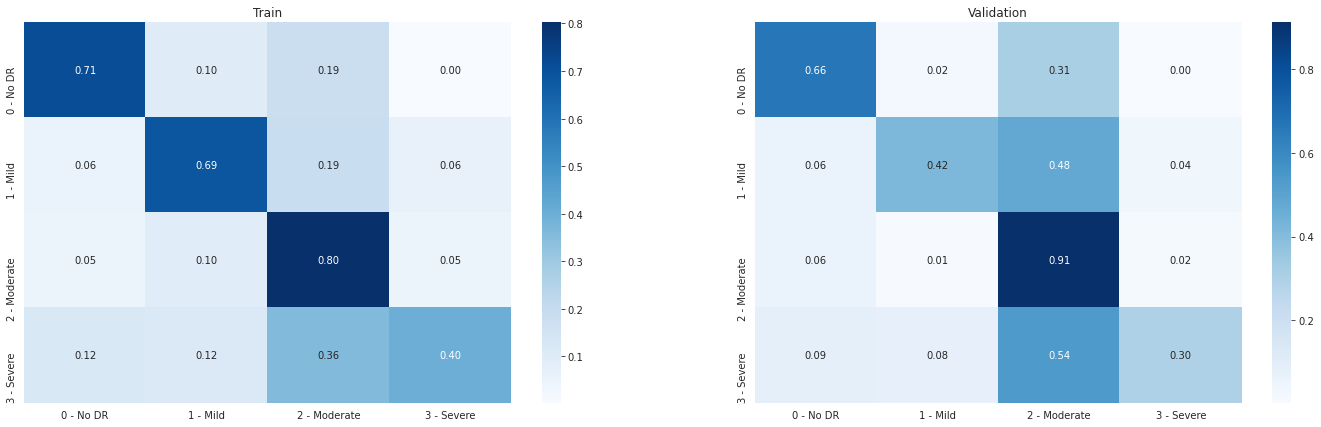

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax2).set_title('Validation')
plt.show()